# Image segmentation
## 1.import module

In [1]:
import tensorflow as tf

from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow_examples.models.pix2pix.pix2pix import upsample
from tensorflow_examples.models.pix2pix.pix2pix import downsample

import tensorflow_advanced_segmentation_models as tasm

from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np

import os

from IPython.display import clear_output

from LoadData import Lab2DataLoader

## 2.load data and test data

In [2]:
train_img, test_img, color_codes = Lab2DataLoader().loadData()
INPUT_SHAPE = train_img['image'].shape[1:]
TRAIN_LENGTH = train_img['image'].shape[0]
TEST_LENGTH = test_img['image'].shape[0]
CLASSES = color_codes.shape[0]

cmap = colors.ListedColormap(color_codes / 255.0, "color_codes")
norm = colors.BoundaryNorm(np.arange(0, CLASSES), cmap.N)

print(f'dataset shape: train {train_img["image"].shape} test {test_img["image"].shape}')

dataset shape: train (2975, 128, 256, 3) test (500, 128, 256, 3)


### 2.1 buile tensorflow dataset

In [3]:
def normalize(image):
    image = tf.cast(image, tf.float32) / 255.0
    return image

### 2.2 Augment random horizontal flip

In [4]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.Sequential([
            tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
            tf.keras.layers.RandomCrop(128, 256, seed=seed),
            # tf.keras.layers.Resizing(128,256,crop_to_aspect_ratio=True)
        ])
        self.augment_labels = tf.keras.Sequential([
            tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
            tf.keras.layers.RandomCrop(128, 256, seed=seed),
            # tf.keras.layers.Resizing(128,256,crop_to_aspect_ratio=True)
        ])

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [5]:
def load_image(dataset):
    input_image = tf.image.resize(dataset['image'], INPUT_SHAPE[:-1])
    input_mask = tf.image.resize(dataset['mask'], INPUT_SHAPE[:-1])
    input_image, input_mask = normalize(input_image), input_mask

    return input_image, input_mask

In [6]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
# STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_img)
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = (
    train_dataset
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .map(Augment())
        .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices(test_img)
test_dataset = (
    test_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(BATCH_SIZE)
)

print(train_dataset)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 256, 1), dtype=tf.float32, name=None))>


### 2.3 display mask image

In [8]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        if i == 0:
            plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        else:
            plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap=cmap)
            # plt.colorbar()
        plt.axis('off')
    plt.show()

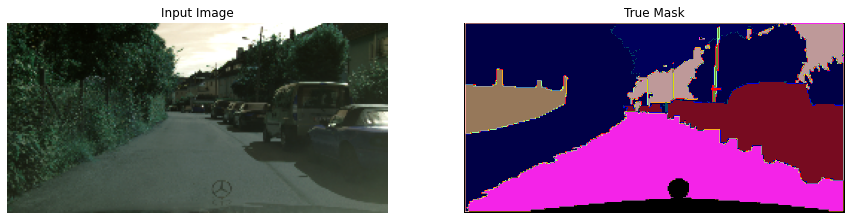

In [9]:
for images, masks in train_dataset.take(1):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

## 3.Define the model
[U-Net](https://arxiv.org/abs/1505.04597) encoder (downsampler) and decoder (upsampler)

In [10]:
class MIoU(tf.keras.metrics.MeanIoU):
    def __init__(
            self,
            num_classes: int,
            name=None,
            dtype=None,
    ):
        super(MIoU, self).__init__(
            num_classes=num_classes,
            name='MIoU',
            dtype=dtype,
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_true = tf.argmax(y_true, axis=-1, output_type=tf.int32)
        y_pred = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
        return super().update_state(y_true, y_pred, sample_weight)

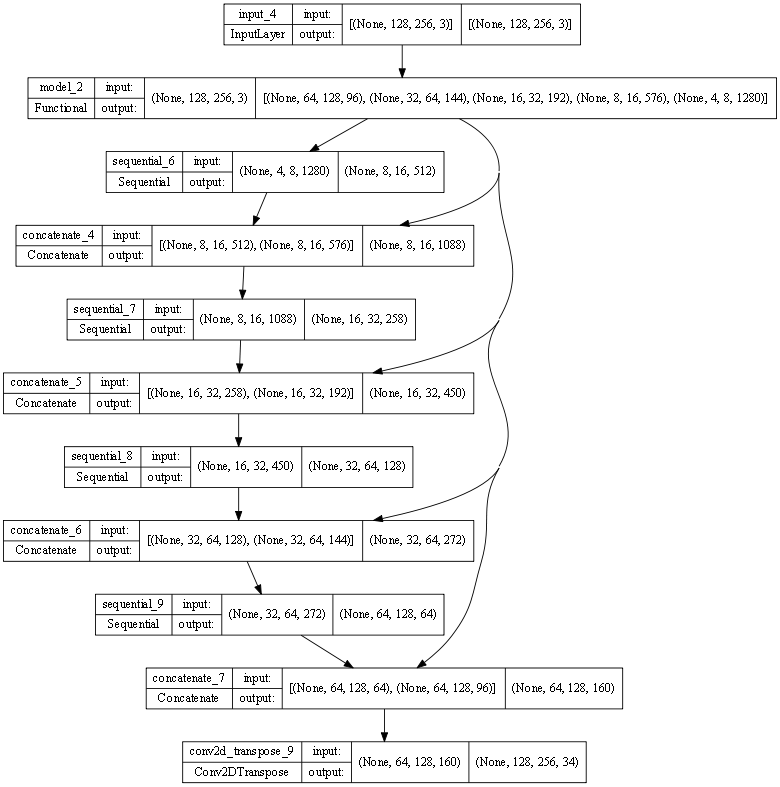

In [22]:
from UNet import UNet

BACKBONE_NAME = 'mobilenetv2'
WEIGHTS = 'imagenet'
HEIGHT = INPUT_SHAPE[0]
WIDTH = INPUT_SHAPE[1]
base_model, base_model_outputs, layer_names = tasm.create_base_model(name=BACKBONE_NAME, weights=WEIGHTS, height=HEIGHT,
                                                         width=WIDTH, include_top=False)

down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),
    pix2pix.upsample(258, 3),
    pix2pix.upsample(128, 3),
    pix2pix.upsample(64, 3),
]

def unet_model(output_channels: int):
    inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

model = unet_model(CLASSES)
model._name = f'UNet_{BACKBONE_NAME}'

SparseCategoricalCrossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# x = tf.keras.layers.Input(shape=(HEIGHT, WIDTH, 3))
# model = tf.keras.Model(inputs=[x], outputs=model.call(x))

model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy,
              metrics=[MIoU(num_classes=CLASSES), 'accuracy'])

tf.keras.utils.plot_model(model,
                          # expand_nested=True,
                          show_shapes=True, dpi=64)

In [23]:
# tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)
model.summary()
# base_model.summary()

Model: "UNet_mobilenetv2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           [(None, 64, 128, 96  2257984     ['input_4[0][0]']                
                                ),                                                                
                                 (None, 32, 64, 144                                               
                                ),                                                                
                                 (None, 16, 32, 192                                

## 4.Train the model

In [24]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [25]:
def show_predictions(dataset=None, random=True, num=1):
    picker = 0
    if random:
        dataset = dataset.shuffle(BUFFER_SIZE)
    if dataset:
        for image, mask in dataset.take(num):
            if random:
                picker = np.random.randint(0, len(image))
            pred_mask = model.predict(image[picker][tf.newaxis, ...])
            display([image[picker], mask[picker], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [26]:
print(model.predict(sample_image[tf.newaxis, ...]).shape)

(1, 128, 256, 34)


### Test show prediction
display prediction in training

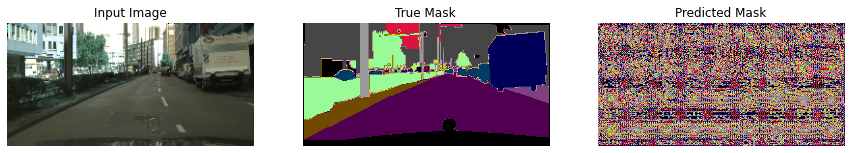

In [27]:
show_predictions(dataset=test_dataset)

### TensorBoard

In [28]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [29]:
checkpoint_directory = "./training_checkpoints"
checkpoint_name = "ckpt"
checkpoint = tf.train.Checkpoint(model=model)
manager = tf.train.CheckpointManager(checkpoint,
                                     f'checkpoint_directory/{model.name}/',
                                     checkpoint_name=checkpoint_name,
                                     max_to_keep=5)

In [30]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(dataset=test_dataset, random=False)
        manager.save()
        print('\nSample Prediction after epoch {}\n'.format(epoch + 1))

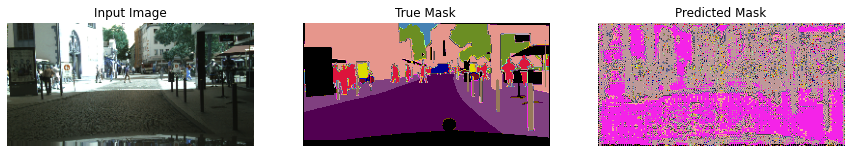


Sample Prediction after epoch 2



KeyboardInterrupt: 

In [31]:
def train(model, manager, EPOCH=20):
    checkpoint.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print(f"Restored from {manager.latest_checkpoint}")
    else:
        print("Initializing Model.")

    initial_epoch = checkpoint.save_counter.numpy()

    log_dir = f"./logs/{model.name}/"
    time_str = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir + time_str, histogram_freq=1)

    model_history = model.fit(train_dataset, epochs=EPOCH + initial_epoch,
                              # steps_per_epoch=STEPS_PER_EPOCH,
                              validation_data=test_dataset,
                              initial_epoch=initial_epoch,
                              # validation_steps=VALIDATION_STEPS,
                              callbacks=[DisplayCallback(), tensorboard_callback])


train(model, manager)

In [ ]:
% tensorboard --logdir logs / fit

In [28]:
for layer in model.layers:
    layer.trainable = True

    print(layer.name + ": " + str(layer.trainable))

input_8: True
model_3: True
atrous_separable_convolution_bn_re_lu_15: True
atrous_spatial_pyramid_pooling_v3_3: True
atrous_separable_convolution_bn_re_lu_16: True
convolution_bn_activation_19: True
convolution_bn_activation_20: True
up_sampling2d_10: True
concatenate_3: True
convolution_bn_activation_21: True
convolution_bn_activation_22: True
convolution_bn_activation_23: True
up_sampling2d_11: True
activation_47: True


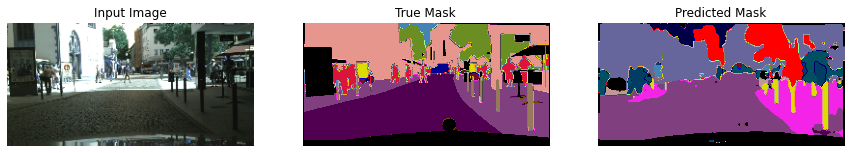


Sample Prediction after epoch 40

186/186 [==============================] - 11s 58ms/step - loss: 0.4024 - iou_score: 0.0359 - accuracy: 0.8806 - val_loss: 0.6840 - val_iou_score: 0.0353 - val_accuracy: 0.8212


In [29]:
train(model, manager)

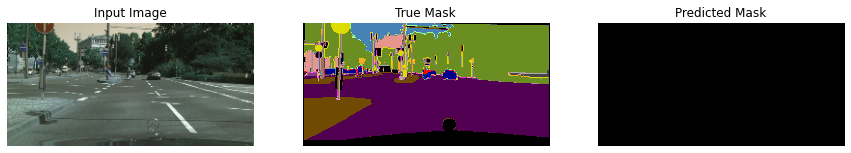

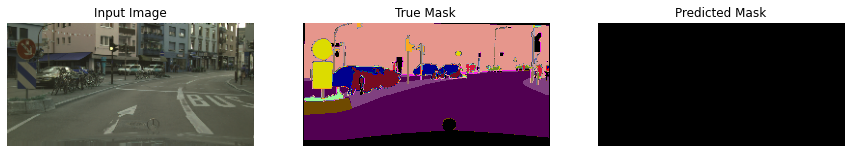

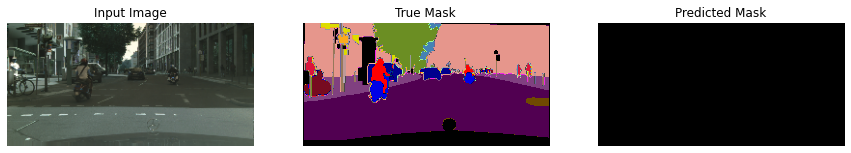

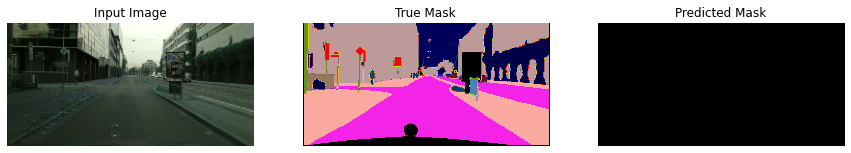

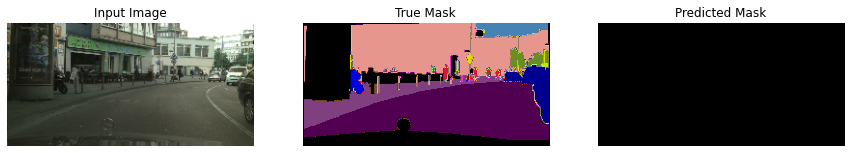

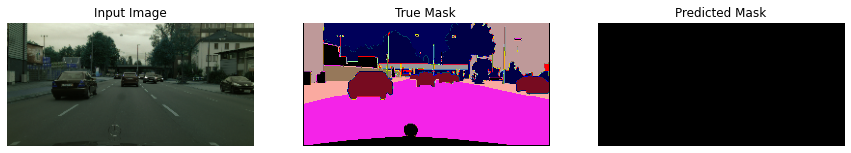

In [20]:
show_predictions(test_dataset, num=3)
show_predictions(train_dataset, num=3)